In [1]:
import catboost
from sklearn.model_selection import RandomizedSearchCV
import pandas as pd
pd.set_option('display.max_columns', None)
from pathlib import Path
import numpy as np
from tqdm import tqdm


from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score

from catboost.utils import get_roc_curve

import sys
sys.path.append('./../../gustav/src/')

from gustav import ncbi, nlm, nih

biological: distance, genome size (in log10 megabases)    
institutional:  multiorganism project, time since first submission, team size, female number, internal or external       
reputation: max h-index, centrality rank, community size (in log10 of all publications), support letter count      
semantic: lexical diversity, argumentation     

`../cache/decisions_all.csv` is provided as Supplementary Table S9.

In [3]:
base = pd.read_csv('../cache/decisions_all.csv')
final_features_x = base[['genome_size', 'years_since', 'argumentation', \
                     'lexical_diversity', 'rank',  'female_authors', 'h_index', 'supportletter_count', \
                      'teamsize', 'communitysize - log', 'multiorganism', 'internal', 'phyla']]
final_feature_y = base[['approved_status']]
semantic_features_x = base[['argumentation', 'lexical_diversity']]
biological_features_x = base[['genome_size',  'phyla', ]]
project_features_x = base[['teamsize', 'female_authors', 'multiorganism','years_since', 'internal', 'supportletter_count']]
reputation_features_x = base[['h_index', 'communitysize - log', 'rank']]

In [5]:
# first random search for hyperparameters
np.random.seed(888)
accuracy = []
models = []
labels = ['all', 'biological', 'project', 'reputation', 'semantic']
for (index, feature), label in tqdm(zip(enumerate([final_features_x, biological_features_x, project_features_x, reputation_features_x, semantic_features_x]), \
                                        labels), total = len(labels)):
    clf = catboost.CatBoostClassifier(
    iterations=500, 
    # use_best_model=True,
    od_pval=0.001,
    od_type="IncToDec",
    loss_function='Logloss', logging_level='Silent')
    grid = {'learning_rate': np.linspace(0, 0.2, 9),
            'depth': np.arange(3, 10),
            'l2_leaf_reg': [1, 3, 5, 7, 9],
           'subsample': np.linspace(0.1, 1, 10),
            "colsample_bylevel": np.linspace(0.1, 1, 10),
           "min_data_in_leaf": np.linspace(0.1, 1, 10)}
    X_train, X_test, y_train, y_test = train_test_split(
    feature, final_feature_y, test_size=0.25, stratify=final_feature_y)
    cat_features = []
        
    if 'internal' in X_train.columns:
        cat_features.append('internal')
    
    if 'multiorganism' in X_train.columns:
        cat_features.append('multiorganism')
    if 'phyla' in X_train.columns:
        cat_features.append('phyla')
    catboost_pool = catboost.Pool(X_train, y_train, cat_features = cat_features)
    randomized_search_result = clf.randomized_search(grid,
                                                   X=catboost_pool,
                                                 search_by_train_test_split=False, verbose = False,
                                                    )

    for i in range(0, 100):
        clf = catboost.CatBoostClassifier(
        iterations=1000, 
        use_best_model=True,
        od_pval=0.001,
            logging_level='Silent',
            depth = randomized_search_result['params']['depth'],
            l2_leaf_reg=randomized_search_result['params']['l2_leaf_reg'],
            subsample=randomized_search_result['params']['subsample'],
            min_data_in_leaf=randomized_search_result['params']['min_data_in_leaf'],
            learning_rate=randomized_search_result['params']['learning_rate'], 
            colsample_bylevel=randomized_search_result['params']['rsm'],
        od_type="IncToDec",
        loss_function='Logloss')

        X_train, X_test, y_train, y_test = train_test_split(
        feature, final_feature_y, test_size=0.25, stratify=final_feature_y)
        
        cat_features = []
        
        if 'internal' in X_train.columns:
            cat_features.append('internal')
        
        if 'multiorganism' in X_train.columns:
            cat_features.append('multiorganism')
        if 'phyla' in X_train.columns:
            cat_features.append('phyla')

        clf = clf.fit(X_train, y_train, 
                cat_features=cat_features,
                eval_set=(X_test, y_test), 
                verbose=False)

        predictions = clf.predict(X_test)

        accuracy.append((accuracy_score(["True" if x else "False" for x in y_test['approved_status']], predictions),label) )
        models.append((clf, index))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [05:00<00:00, 60.01s/it]


In [6]:
accuracy_df = pd.DataFrame(accuracy, columns = ['accuracy', 'feature_type'])

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
sns.set_style('white', rc={
    'xtick.bottom': True,
    'ytick.left': True,
})

sns.color_palette("Set1")

matplotlib.rc('font', family='Helvetica') 
matplotlib.rc('pdf', fonttype=42)
matplotlib.rc('text', usetex='false') 
matplotlib.rcParams['axes.unicode_minus'] = False
matplotlib.rcParams.update({"axes.labelsize": 10,
"xtick.labelsize": 10,
"ytick.labelsize": 10,
"legend.fontsize": 10,
"font.size":10})


matplotlib.rcParams['xtick.major.size'] = 2
matplotlib.rcParams['xtick.major.width'] = 1
matplotlib.rcParams['xtick.minor.size'] = 1
matplotlib.rcParams['xtick.minor.width'] = 1

matplotlib.rcParams['ytick.major.size'] = 2
matplotlib.rcParams['ytick.major.width'] = 1
matplotlib.rcParams['ytick.minor.size'] = 1
matplotlib.rcParams['ytick.minor.width'] = 1

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


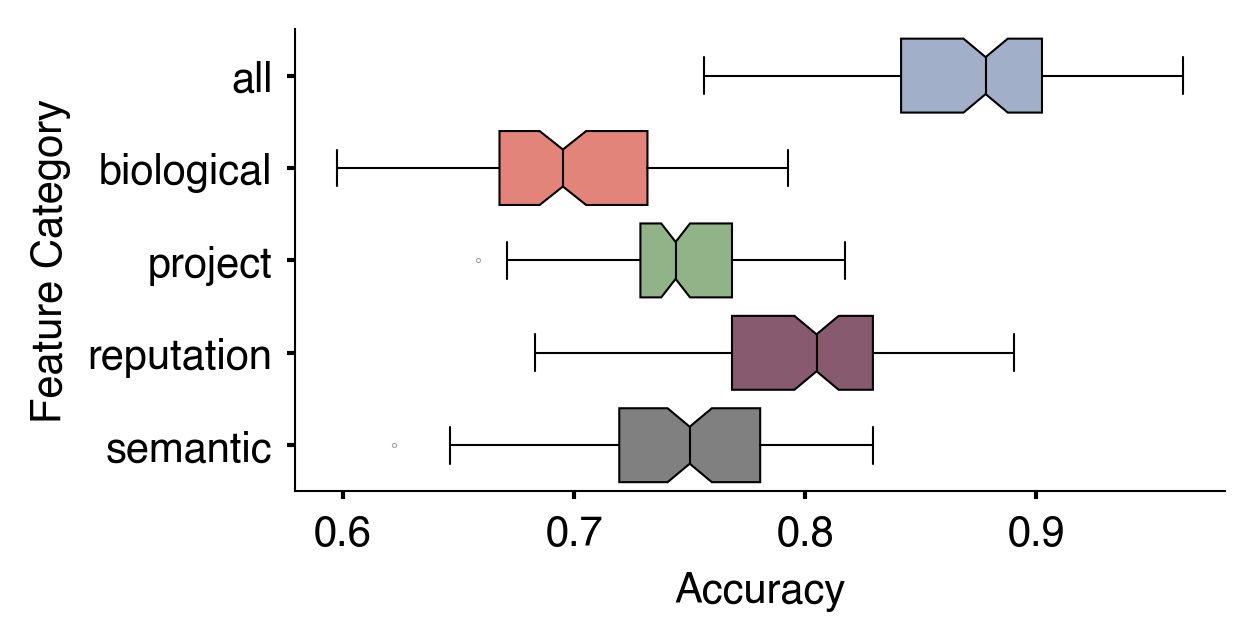

In [8]:


fig, ax = plt.subplots(1, 1, figsize = (4, 2), dpi = 300 )
flierprops = dict(markerfacecolor='1', markersize=0.5,
              marker = '.', alpha = 0.5)

sns.boxplot(accuracy_df.explode('accuracy'), x = 'accuracy', y ='feature_type', notch = True, flierprops = flierprops, \
            palette = ["#9CADCE", "#F37668", "#8CBA80", "#8E5270", 'gray', 'red', 'green', 'black', 'pink'], boxprops = {"edgecolor": "black"}, \
            medianprops = {'color':'black'}, whiskerprops={'color':'black'}, capprops={'color':'black'}, linewidth = 0.5)

ax.set_xlabel('Accuracy')
ax.set_ylabel("Feature Category")
ax.legend(loc = 'lower right', frameon = False  )
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_color('black')
ax.xaxis.label.set_color('black')
ax.tick_params(axis='x', colors='black')
ax.yaxis.label.set_color('black')
ax.tick_params(axis='y', colors='black')
ax.spines['bottom'].set_linewidth(0.5)
ax.spines['left'].set_linewidth(0.5)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.show()

Calculate SHAP without the independence condition assumption. This will take some time as we feed 13 features.

In [ ]:
%%time


final_features_x['phyla'] = pd.Categorical(final_features_x['phyla'])
for i, model in tqdm(enumerate(models), total = len(models)):
    print(i)
    if model[1] == 0 and i > 8:
    # -1 is not a possibel value for these categories, so we give it this to ensure split
        final_features_x['genome_size'] = final_features_x['genome_size'].fillna(-1)
        final_features_x['female_authors'] = final_features_x['female_authors'].fillna(-1)
        final_features_x['teamsize'] = final_features_x['teamsize'].fillna(-1)
        final_features_x['rank'] = final_features_x['rank'].fillna(-1)
        final_features_x['h_index'] = final_features_x['h_index'].fillna(-1)
        final_features_x['communitysize - log'] = final_features_x['communitysize - log'].fillna(-1)

        # we modify to allow for categorical 
        def predict_model(model, data):
            data['internal'] = pd.Categorical(data['internal'])
            data['multiorganism'] = pd.Categorical(data['multiorganism'])
            data['phyla'] = pd.Categorical(data['phyla'])
            test_data = catboost.Pool(
            data=data,
            cat_features=[ 'internal', 'multiorganism', 'phyla'], )
            
        
            return model.predict_proba(test_data)[:, 1]
        
        df_shapley, pred_explain, internal, timing = explain(
            model = model[0],
        x_train =final_features_x,
            x_explain = final_features_x,
            approach = 'ctree',
            predict_model=predict_model,
            prediction_zero = 0.56,
            n_batches = 50)
    
        df_shapley.to_parquet(f"../models/model_organisms/shapley_values/df_shapley_240521_{i}.parquet")

In [9]:
# now get the ROC curve data
np.random.seed(888)
roc_curve_data = []
all_aucs = []
for index, feature in tqdm(enumerate([final_features_x, biological_features_x, semantic_features_x, project_features_x,\
                                      reputation_features_x]), total = 5):
    clf = catboost.CatBoostClassifier(
    iterations=500, 
    # use_best_model=True,
    od_pval=0.001,
    od_type="IncToDec",
    loss_function='Logloss', logging_level='Silent')
    grid = {'learning_rate': np.linspace(0, 0.2, 9),
            'depth': np.arange(3, 10),
            'l2_leaf_reg': [1, 3, 5, 7, 9],
           'subsample': np.linspace(0.1, 1, 10),
            "colsample_bylevel": np.linspace(0.1, 1, 10),
           "min_data_in_leaf": np.linspace(0.1, 1, 10)}
    X_train, X_test, y_train, y_test = train_test_split(
    feature, final_feature_y, test_size=0.25, stratify=final_feature_y)
    cat_features = []
        
    if 'internal' in X_train.columns:
        cat_features.append('internal')
    
    if 'multiorganism' in X_train.columns:
        cat_features.append('multiorganism')
    if 'phyla' in X_train.columns:
        cat_features.append('phyla')
    catboost_pool = catboost.Pool(X_train, y_train, cat_features = cat_features)
    randomized_search_result = clf.randomized_search(grid,
                                                   X=catboost_pool,
                                                 search_by_train_test_split=False, verbose = False,
                                                    )
    
    mean_fpr = np.linspace(0, 1, 100)
    tprs = []
    aucs = []
    for i in range(0, 100):
        clf = catboost.CatBoostClassifier(
        iterations=1000, 
        use_best_model=True,
        od_pval=0.001,
            logging_level='Silent',
            depth = randomized_search_result['params']['depth'],
            l2_leaf_reg=randomized_search_result['params']['l2_leaf_reg'],
            subsample=randomized_search_result['params']['subsample'],
            min_data_in_leaf=randomized_search_result['params']['min_data_in_leaf'],
            learning_rate=randomized_search_result['params']['learning_rate'], 
            colsample_bylevel=randomized_search_result['params']['rsm'],
        od_type="IncToDec",
        loss_function='Logloss')

        X_train, X_test, y_train, y_test = train_test_split(
        feature, final_feature_y, test_size=0.25, stratify=final_feature_y)

        cat_features = []
        if 'figure' in X_train.columns:
            cat_features.append('figure')
        if 'phyla' in X_train.columns:
            cat_features.append('phyla')
        if 'multiorganism' in X_train.columns:
            cat_features.append('multiorganism')
        clf = clf.fit(X_train, y_train, 
                cat_features=cat_features,
                eval_set=(X_test, y_test), 
                verbose=False)
        
        catboost_pool = catboost.Pool(X_test, y_test, cat_features = cat_features)
        fpr, tpr, thresholds = get_roc_curve(clf, catboost_pool)
        
        score = roc_auc_score(y_test, clf.predict_proba(X_test)[:,1], average = 'micro')
        interp_tpr = np.interp(mean_fpr, fpr, tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(score)
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = np.mean(aucs)
    std_auc = np.std(aucs)
    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    all_aucs.append(aucs)
    roc_curve_data.append((mean_auc, mean_fpr, mean_tpr, std_auc, tprs_lower, tprs_upper, index))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [05:11<00:00, 62.31s/it]


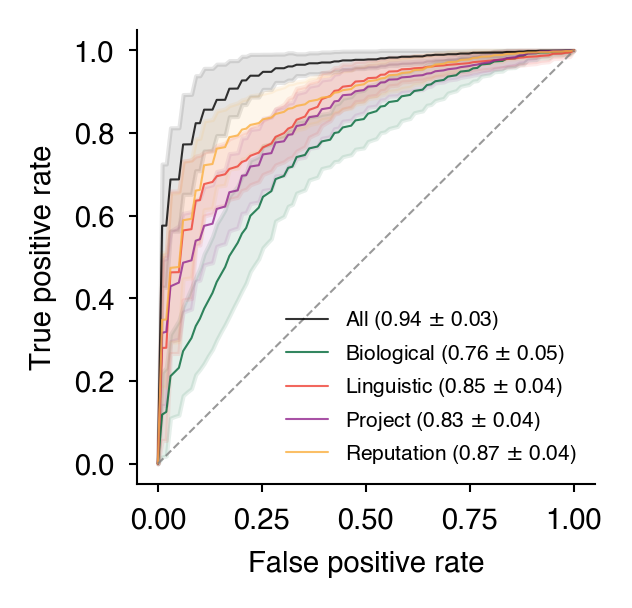

In [10]:
labels = [ 'All','Biological',  'Linguistic', 'Project', 'Reputation',]

colors = ["black", "#006838", '#EF4136', "#92278F", "#FBB040", ]

matplotlib.rcParams.update({"axes.labelsize": 7,
"xtick.labelsize": 7,
"ytick.labelsize": 7,
"legend.fontsize": 5,
"font.size":7})
matplotlib.rc('font', family='Helvetica') 
matplotlib.rc('pdf', fonttype=42)
matplotlib.rc('text', usetex='false') 
matplotlib.rcParams['axes.unicode_minus'] = False

matplotlib.rcParams['xtick.major.size'] = 2
matplotlib.rcParams['xtick.major.width'] = 0.5
matplotlib.rcParams['xtick.minor.size'] = 2
matplotlib.rcParams['xtick.minor.width'] = 0.5

matplotlib.rcParams['ytick.major.size'] = 2
matplotlib.rcParams['ytick.major.width'] = 0.5
matplotlib.rcParams['ytick.minor.size'] = 2
matplotlib.rcParams['ytick.minor.width'] = 0.5

fig, ax = plt.subplots(1, 1, figsize = (50 * (1/2.54/10), 50 * (1/2.54/10)), dpi = 300 )

for roc_data, label, color in zip(roc_curve_data, labels, colors):
    if label in ["Biological", "Project", "Reputation", "Linguistic", "All"]:
        ax.plot(roc_data[1], roc_data[2], color=color,
                label=r'%s (%0.2f $\pm$ %0.2f)' % (label, roc_data[0], roc_data[3] ),
                lw=0.5, alpha=.8)
    
        ax.fill_between(roc_data[1], roc_data[4], roc_data[5], color=color, alpha=.1,)

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="")
ax.plot([0, 1], [0, 1], linestyle='--', lw=0.5, color='gray', alpha=.8)
ax.legend(loc = 'lower right', frameon = False  )
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_color('black')
ax.xaxis.label.set_color('black')
ax.tick_params(axis='x', colors='black')
ax.yaxis.label.set_color('black')
ax.tick_params(axis='y', colors='black')
ax.spines['bottom'].set_linewidth(0.5)
ax.spines['left'].set_linewidth(0.5)
ax.set_ylabel('True positive rate')
ax.set_xlabel('False positive rate')

leg = ax.legend(frameon = False)

for text in leg.get_texts():
    text.set_color('k')

    
plt.show()

We can load the shapley values together

```python
../models/model_organisms/shapley_values/").glob("*240521*.parquet")
```
parquet files are created earlier in this notebook.

In [11]:
all_parquets = []
final_features_x_to_plot = final_features_x.copy()
final_features_x_to_plot['multiorganism'] = final_features_x_to_plot['multiorganism'].astype(int)
final_features_x_to_plot['internal'] = final_features_x_to_plot['internal'].astype(int)
final_features_x_to_plot.columns = [i + "_x" for i in final_features_x_to_plot.columns]

for i, parquet in enumerate(Path("../models/model_organisms/shapley_values/").glob("*240521*.parquet")):
    temp = pd.read_parquet(parquet)
    temp['model_idx'] = i
    all_parquets.append(pd.concat([temp.reset_index(drop = False, names = 'feature_idx'), final_features_x_to_plot.reset_index(drop = True)], axis = 1))

In [12]:
combined = pd.concat(all_parquets)
combined['feature_idx'] = combined['feature_idx'].astype(int)

In [43]:
h_index_df = combined[['h_index_x', 'h_index', 'feature_idx', 'model_idx']].sort_values('h_index_x')
h_index_df['moving'] = h_index_df['h_index'].rolling(window=50, center = True).mean()
h_index_df = h_index_df.loc[h_index_df.moving.notna()]

In [30]:
community_size_df = combined[['communitysize - log_x', 'communitysize - log']].sort_values('communitysize - log_x')
community_size_df['moving'] = community_size_df["communitysize - log"].rolling(window=50, center = True).mean()
community_size_df  = community_size_df.loc[community_size_df.moving.notna()]

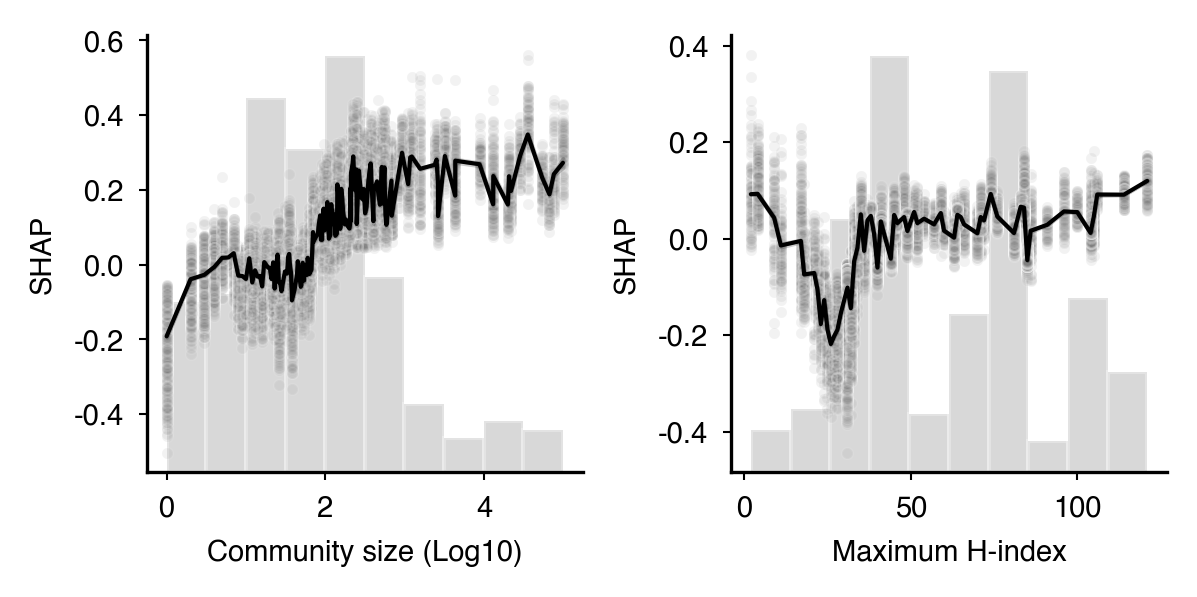

In [44]:

sns.color_palette("Set1")

matplotlib.rcParams.update({"axes.labelsize": 7,
"xtick.labelsize": 7,
"ytick.labelsize": 7,
"legend.fontsize": 5,
"font.size":7})
matplotlib.rc('font', family='Helvetica') 
matplotlib.rc('pdf', fonttype=42)
matplotlib.rc('text', usetex='false') 
matplotlib.rcParams['axes.unicode_minus'] = False

matplotlib.rcParams['xtick.major.size'] = 2
matplotlib.rcParams['xtick.major.width'] = 0.5
matplotlib.rcParams['xtick.minor.size'] = 2
matplotlib.rcParams['xtick.minor.width'] = 0.5

matplotlib.rcParams['ytick.major.size'] = 2
matplotlib.rcParams['ytick.major.width'] = 0.5
matplotlib.rcParams['ytick.minor.size'] = 2
matplotlib.rcParams['ytick.minor.width'] = 0.5

fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (40 * (1/10), 20* (1/10)), dpi = 300 )

twiny = ax[0].twinx()
twiny.get_yaxis().set_ticks([])
ax[0].set_zorder(twiny.get_zorder()+1)
ax[0].set_frame_on(False)
twiny.set_frame_on(True)

twiny.hist(combined['communitysize - log_x'], density = True, color= 'grey', alpha = 0.3)
sns.scatterplot(combined, x = 'communitysize - log_x', y = 'communitysize - log', alpha = 0.1, s = 7, c = 'grey', ax = ax[0], linewidth = 0.5)
sns.lineplot(community_size_df.loc[community_size_df['communitysize - log_x'].notna()], x = 'communitysize - log_x', y = 'moving', ax = ax[0], c = 'k', linewidth =1)

twiny.spines['right'].set_visible(False)
twiny.spines['top'].set_visible(False)
twiny.spines['bottom'].set_color('black')
twiny.spines['left'].set_color('black')

ax[0].set_ylabel('SHAP')
ax[0].set_xlabel("Community size (Log10)")

ax[0].spines['right'].set_visible(False)
ax[0].spines['top'].set_visible(False)
ax[0].spines['bottom'].set_color('black')
ax[0].spines['left'].set_color('black')
ax[0].xaxis.label.set_color('black')
ax[0].tick_params(axis='x', colors='black')
ax[0].yaxis.label.set_color('black')
ax[0].tick_params(axis='y', colors='black')
ax[0].spines['bottom'].set_linewidth(0.5)
ax[0].spines['left'].set_linewidth(0.5)

twiny = ax[1].twinx()
twiny.get_yaxis().set_ticks([])
ax[1].set_zorder(twiny.get_zorder()+1)
ax[1].set_frame_on(False)
twiny.set_frame_on(True)
twiny.hist(combined['h_index_x'], density = True, color= 'grey', alpha = 0.3)
sns.scatterplot(combined, x = 'h_index_x', y = 'h_index', alpha = 0.1, s = 7, c = 'grey', ax = ax[1], linewidth = 0.5)
sns.lineplot(h_index_df.loc[h_index_df['h_index_x'].notna()], x = "h_index_x", y = "moving", ax = ax[1], c = 'k', linewidth = 1)


twiny.spines['right'].set_visible(False)
twiny.spines['top'].set_visible(False)
twiny.spines['bottom'].set_color('black')
twiny.spines['left'].set_color('black')


ax[1].set_ylabel('SHAP')
ax[1].set_xlabel("Maximum H-index")
# ax[1].set_xlim([0, 0.2])
    
ax[1].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)
ax[1].spines['bottom'].set_color('black')
ax[1].spines['left'].set_color('black')
ax[1].xaxis.label.set_color('black')
ax[1].tick_params(axis='x', colors='black')
ax[1].yaxis.label.set_color('black')
ax[1].tick_params(axis='y', colors='black')
ax[1].spines['bottom'].set_linewidth(0.5)
ax[1].spines['left'].set_linewidth(0.5)


fig.tight_layout()
plt.show()